Try to access data 

In [3]:
from IPython.display import clear_output
! pip install hub


[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [24]:
! pip install google-cloud-storage
! pip install deeplake


[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [6]:
import numpy as np
import pandas as pd
import os
import json
from matplotlib import pyplot as plt
from google.cloud import storage

In [21]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./credentials.json"

client = storage.Client()

bucket_name = 'foodbuddy-dataset'
bucket = client.get_bucket(bucket_name)

blobs = bucket.list_blobs()

print("Fichiers dans le bucket :")
for blob in blobs:
    print(blob.name)

Fichiers dans le bucket :
public_test_release_2.0/images/007058.jpg
public_test_release_2.0/images/007953.jpg
public_test_release_2.0/images/007997.jpg
public_test_release_2.0/images/008553.jpg
public_test_release_2.0/images/008849.jpg
public_test_release_2.0/images/008867.jpg
public_test_release_2.0/images/009675.jpg
public_test_release_2.0/images/010090.jpg
public_test_release_2.0/images/011397.jpg
public_test_release_2.0/images/012020.jpg
public_test_release_2.0/images/012030.jpg
public_test_release_2.0/images/012804.jpg
public_test_release_2.0/images/013183.jpg
public_test_release_2.0/images/013438.jpg
public_test_release_2.0/images/013676.jpg
public_test_release_2.0/images/013836.jpg
public_test_release_2.0/images/014372.jpg
public_test_release_2.0/images/014868.jpg
public_test_release_2.0/images/015786.jpg
public_test_release_2.0/images/016313.jpg
public_test_release_2.0/images/016840.jpg
public_test_release_2.0/images/017119.jpg
public_test_release_2.0/images/017361.jpg
public_t

In [22]:
print(os.listdir('./raw_data'))

['public_test_release_2.0', 'public_validation_set_2.0', 'public_training_set_release_2.0']


In [30]:
def create_dataframe(annotations_path):
    with open(annotations_path, 'r') as file:
        data = json.load(file)

    images = pd.DataFrame(data['images']).rename(columns={'id': 'image_id'})[['image_id', 'file_name', 'width', 'height']]

    categories = pd.DataFrame(data['categories'])[['id', 'name', 'name_readable']]
    categories.rename(columns={'id': 'category_id'}, inplace=True)

    usecols = ['image_id', 'category_id']
    annotations = pd.DataFrame(data['annotations'])[usecols]

    dataframe = annotations.merge(categories, on='category_id').merge(images, on='image_id')[['file_name', 'name', 'name_readable']]

    return dataframe

In [28]:
annotation_train_path = './raw_data/public_training_set_release_2.0/annotations.json'
image_train_path = './raw_data/public_training_set_release_2.0/images'
annotation_val_path = './raw_data/public_validation_set_2.0/annotations.json'
image_val_path = './raw_data/public_validation_set_release_2.0/images'

In [106]:
train_df = create_dataframe(annotation_train_path).drop_duplicates().reset_index(drop=True)
val_df = create_dataframe(annotation_val_path).drop_duplicates().reset_index(drop=True)

In [32]:
train_df.to_csv('data_train_set.csv', index=False)
val_df.to_csv('data_val_set.csv', index=False)

In [107]:
train_df

,file_name,name,name_readable
0,131094.jpg,soft-cheese,Soft cheese
1,131094.jpg,ham-raw,"Ham, raw"
2,131094.jpg,hard-cheese,Hard cheese
3,131094.jpg,bread-wholemeal,"Bread, wholemeal"
4,131094.jpg,cottage-cheese,Cottage cheese
...,...,...,...
70392,131053.jpg,dairy-ice-cream,Dairy ice cream
70393,131066.jpg,coffee-with-caffeine,"Coffee, with caffeine"
70394,131071.jpg,bread-wholemeal,"Bread, wholemeal"
70395,131071.jpg,butter,Butter


### Combien de valeurs uniques ?

In [74]:
train_df['file_name'].nunique()

39962

In [108]:
train_df = train_df.groupby('file_name')['name'].agg(list).reset_index()
train_df

,file_name,name
0,006316.jpg,[cake-chocolate]
1,006331.jpg,[sugar-melon]
2,006335.jpg,"[mixed-salad-chopped-without-sauce, salad-dres..."
3,006346.jpg,"[chips-french-fries, hamburger, hamburger-bun,..."
4,006351.jpg,[pie-plum-baked-with-cake-dough]
...,...,...
39957,185804.jpg,"[carrot-raw, egg, cheese, bread-white, ham]"
39958,185837.jpg,"[salad-leaf-salad-green, fennel]"
39959,185857.jpg,[grapes]
39960,185859.jpg,[tiramisu]


In [109]:
train_df['nbr_ingredient'] = train_df['name'].agg(len)
train_df_ingr = train_df.sort_values('nbr_ingredient', ascending=True)
train_df_ingr

/tmp/ipykernel_6371/3032456753.py:1: FutureWarning: using <built-in function len> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  train_df['nbr_ingredient'] = train_df['name'].agg(len)


,file_name,name,nbr_ingredient
19717,085898.jpg,[tea-fruit],1
19735,085954.jpg,[ketchup],1
19737,085956.jpg,[wine-red],1
34877,160654.jpg,[tea],1
34879,160667.jpg,[coffee-with-caffeine],1
...,...,...,...
27575,118503.jpg,"[pork, sugar-melon, watermelon-fresh, grapes, ...",11
35496,163431.jpg,"[corn, naan-indien-bread, chickpeas, raspberri...",11
4562,025627.jpg,"[salmon, mushroom, chicken-breast, mustard, ch...",11
9762,045357.jpg,"[watermelon-fresh, apple, lemon, eggplant, fet...",12


(array([2.4302e+04, 7.4500e+03, 4.4570e+03, 2.1350e+03, 9.0500e+02,
        4.2300e+02, 0.0000e+00, 1.7700e+02, 6.8000e+01, 2.4000e+01,
        1.2000e+01, 7.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 1.        ,  1.85714286,  2.71428571,  3.57142857,  4.42857143,
         5.28571429,  6.14285714,  7.        ,  7.85714286,  8.71428571,
         9.57142857, 10.42857143, 11.28571429, 12.14285714, 13.        ]),
 <BarContainer object of 14 artists>)

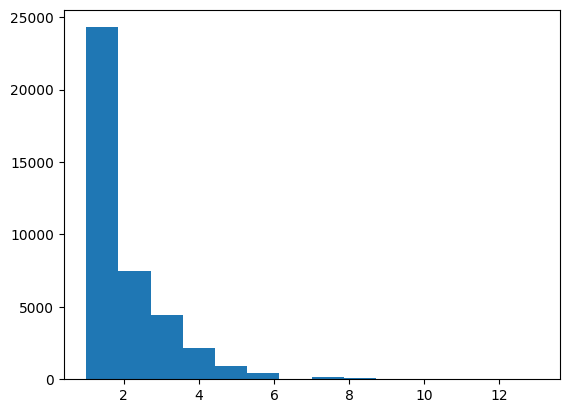

In [66]:
plt.hist(train_df_ingr['nbr_ingredient'], bins=14)

In [114]:
indice = int(np.where(train_df_ingr['nbr_ingredient']>1)[0][0])

train_samples = train_df_ingr.iloc[:indice]
train_samples

,file_name,name,nbr_ingredient
19717,085898.jpg,[tea-fruit],1
19735,085954.jpg,[ketchup],1
19737,085956.jpg,[wine-red],1
34877,160654.jpg,[tea],1
34879,160667.jpg,[coffee-with-caffeine],1
...,...,...,...
9432,043821.jpg,[pasta-spaghetti],1
37385,173416.jpg,[mixed-vegetables],1
9438,043846.jpg,[porridge-prepared-with-partially-skimmed-milk],1
11461,053141.jpg,[pasta-penne],1


In [111]:
train_sample_by_ingr = train_sample.sort_values('name')
train_sample_by_ingr['name_str'] = train_sample_by_ingr['name'].apply(lambda x: ''.join(x))
train_sample_by_ingr['count'] = train_sample_by_ingr.groupby('name_str')['name'].transform('count')
train_sample_by_ingr = train_sample_by_ingr.sort_values('count', ascending=False)
train_sample_by_ingr = train_sample_by_ingr.groupby('name_str')['count'].apply('count')
train_sample_by_ingr = pd.DataFrame(train_sample_by_ingr).sort_values(by='count', ascending=False).head(30)
train_sample_by_ingr

,count
name_str,
water,2684
coffee-with-caffeine,1176
bread-white,916
wine-red,690
apple,651
espresso-with-caffeine,443
banana,436
tea,428
wine-white,419


<Figure size 3000x1000 with 0 Axes>

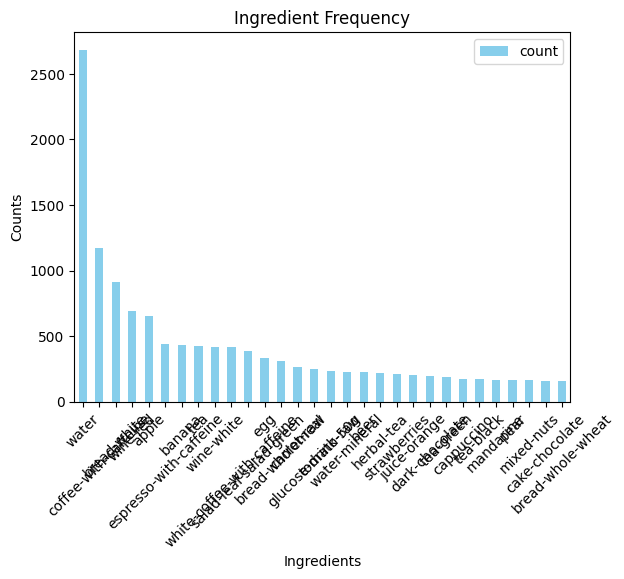

In [103]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(30,10))
train_sample_by_ingr.plot(kind='bar', color='skyblue')

plt.title('Ingredient Frequency')
plt.xlabel('Ingredients')
plt.ylabel('Counts')
plt.xticks(rotation=45)  # Rotates labels to make them readable
plt.show()

In [105]:
train_sample_by_ingr

,count
name_str,
water,2684
coffee-with-caffeine,1176
bread-white,916
wine-red,690
apple,651
espresso-with-caffeine,443
banana,436
tea,428
wine-white,419


In [115]:
desired_ingredients = ['apple', 'salad-leaf-salad-green', 'egg', 'bread-wholemeal', 'carrot-raw', 'tomato-raw', 'beer', 'strawberries', 'dark-chocolate', 'mandarine', 'pear', 'mixed-nuts', 'cake-chocolate', 'bread-whole-wheat']

train_df['name'] = train_df['name'].apply(lambda x: ''.join(x))
train_df_sample = train_df[train_df['name'].isin(desired_ingredients)]
train_df_sample

,file_name,name,nbr_ingredient
0,006316.jpg,cake-chocolate,1
6,006458.jpg,pear,1
10,006493.jpg,apple,1
15,006508.jpg,salad-leaf-salad-green,1
40,006615.jpg,apple,1
...,...,...,...
39909,185123.jpg,beer,1
39911,185136.jpg,salad-leaf-salad-green,1
39928,185351.jpg,apple,1
39929,185366.jpg,apple,1


In [116]:
train_df_sample.to_csv('train_df_sample.csv', index=False)